In [1]:
import pandas as pd
import torch
from torch import nn, optim
# from torch.optim import lr_scheduler
# from torch.autograd import Variable, Function
from torchvision import datasets, models, transforms, utils
import torchvision
# import torch.nn.functional as F
import torch.nn as nn
import pandas
import os
import zipfile
import splitfolders

In [2]:
splitfolders.ratio('../dataset/flowers_16', output="../dataset/Data_16", seed=1337, ratio=(.8, .1, .1))

Copying files: 15740 files [00:19, 800.81 files/s]


In [3]:
train_dir = '../dataset/Data_16/train'
valid_dir = '../dataset/Data_16/val'
test_dir = '../dataset/Data_16/test'

In [4]:
# train_dir = '../dataset/flowerClass/Flower Classification/Flower Classification/Training Data'
# valid_dir = '../dataset/flowerClass/Flower Classification/Flower Classification/Validation Data'
# test_dir = '../dataset/flowerClass/Flower Classification/Flower Classification/Testing Data'


In [5]:
image_data_transforms = {
    'training': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [6]:
batch_size = 128
training_data = torchvision.datasets.ImageFolder(train_dir, transform=image_data_transforms['training'])
validation_data = torchvision.datasets.ImageFolder(valid_dir, transform=image_data_transforms['validation'])
testing_data = torchvision.datasets.ImageFolder(test_dir, transform=image_data_transforms['testing'])

train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size)


In [7]:
class_names = training_data.classes
class_names

['astilbe',
 'bellflower',
 'black_eyed_susan',
 'calendula',
 'california_poppy',
 'carnation',
 'common_daisy',
 'coreopsis',
 'daffodil',
 'dandelion',
 'iris',
 'magnolia',
 'rose',
 'sunflower',
 'tulip',
 'water_lily']

In [8]:
model = models.resnet18(num_classes=len(class_names),pretrained=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

c:\Users\utsav\OneDrive\Documents\AI\FlowerClassification\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\utsav\OneDrive\Documents\AI\FlowerClassification\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Device: cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
num_epochs = 20
dataframe = pandas.DataFrame({
    "Epoch":pandas.Series(dtype="int"),
    "train_loss":pandas.Series(dtype="float"),
    "train_accuracy":pandas.Series(dtype="float"),
    "val_loss":pandas.Series(dtype="float"),
    "val_accuracy":pandas.Series(dtype="float")
})
for epoch in range(num_epochs):
    # Train mode
    model.train()
    train_loss = 0
    train_correct = 0
    for feature, target in train_loader:
        feature, target = feature.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(feature)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * feature.shape[0]
        train_correct += (output.argmax(1) == target).sum().item()
    train_loss /= len(training_data)
    train_accuracy = train_correct / len(training_data)

    # Validation mode
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for feature, target in validation_loader:
            feature, target = feature.to(device), target.to(device)
            output = model(feature)
            loss = criterion(output, target)
            val_loss += loss.item() * feature.shape[0]
            val_correct += (output.argmax(1) == target).sum().item()
    val_loss /= len(validation_data)
    val_accuracy = val_correct / len(validation_data)

    # Print results for this epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%'
          .format(epoch+1, num_epochs, train_loss, train_accuracy*100, val_loss, val_accuracy*100))
    dataframe.loc[len(dataframe.index)] = [epoch+1, train_loss, train_accuracy, val_loss, val_accuracy]


Epoch [1/20], Train Loss: 1.7852, Train Acc: 39.47%, Val Loss: 1.7038, Val Acc: 41.16%
Epoch [2/20], Train Loss: 1.3781, Train Acc: 53.23%, Val Loss: 1.4261, Val Acc: 50.41%
Epoch [3/20], Train Loss: 1.1549, Train Acc: 61.21%, Val Loss: 1.2392, Val Acc: 59.92%
Epoch [4/20], Train Loss: 1.0351, Train Acc: 65.16%, Val Loss: 1.0545, Val Acc: 66.62%
Epoch [5/20], Train Loss: 0.8572, Train Acc: 71.29%, Val Loss: 1.5997, Val Acc: 56.16%
Epoch [6/20], Train Loss: 0.7381, Train Acc: 75.12%, Val Loss: 0.8442, Val Acc: 71.41%
Epoch [7/20], Train Loss: 0.6625, Train Acc: 77.46%, Val Loss: 0.8703, Val Acc: 70.33%
Epoch [8/20], Train Loss: 0.6032, Train Acc: 80.19%, Val Loss: 1.1416, Val Acc: 66.37%
Epoch [9/20], Train Loss: 0.5302, Train Acc: 82.13%, Val Loss: 0.8509, Val Acc: 75.11%
Epoch [10/20], Train Loss: 0.4718, Train Acc: 84.26%, Val Loss: 0.7189, Val Acc: 77.60%
Epoch [11/20], Train Loss: 0.4289, Train Acc: 85.55%, Val Loss: 0.6610, Val Acc: 78.56%
Epoch [12/20], Train Loss: 0.3681, Train 

In [11]:
dataframe.head()

,Epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,1.0,1.785154,0.394724,1.703845,0.411615
1,2.0,1.378080,0.532338,1.426128,0.504148
2,3.0,1.154904,0.612109,1.239244,0.599234
3,4.0,1.035107,0.651597,1.054468,0.666241
4,5.0,0.857157,0.712856,1.599712,0.561583


In [12]:
import matplotlib.pyplot as plot

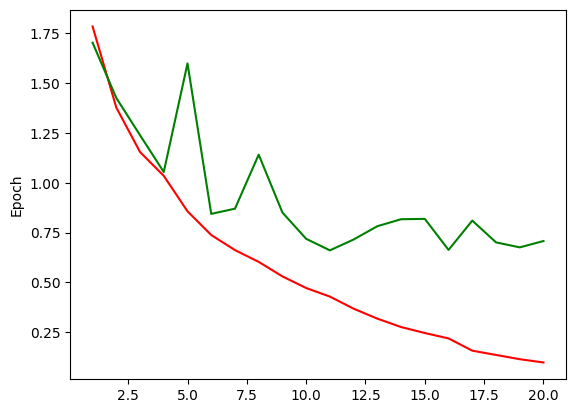

<Figure size 640x480 with 0 Axes>

In [13]:
plot.plot(dataframe.Epoch,dataframe.train_loss,'r',label="Training Loss")
plot.plot(dataframe.Epoch,dataframe.val_loss,'g',label="Validation Loss")
plot.ylabel("Epoch")
plot.show()
plot.savefig("R_net_16_Classes_Loss.jpg")

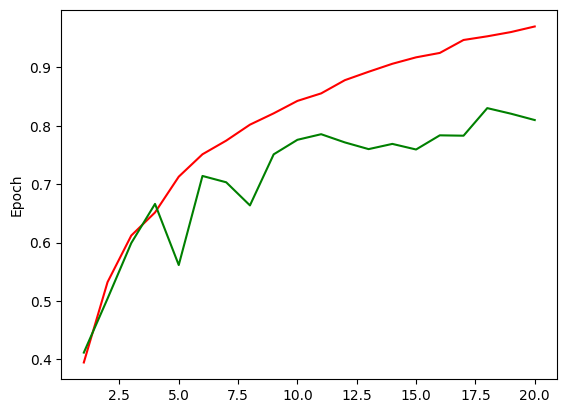

<Figure size 640x480 with 0 Axes>

In [14]:
plot.plot(dataframe.Epoch,dataframe.train_accuracy,'r',label="Training Accuracy")
plot.plot(dataframe.Epoch,dataframe.val_accuracy,'g',label='Validation Accuracy')
plot.ylabel("Epoch")
plot.show()
plot.savefig("R_net_16_Classes_Accuracy.jpg")

In [15]:
model.eval()  # set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test accuracy: %d %%' % (100 * correct / total))


Test accuracy: 78 %


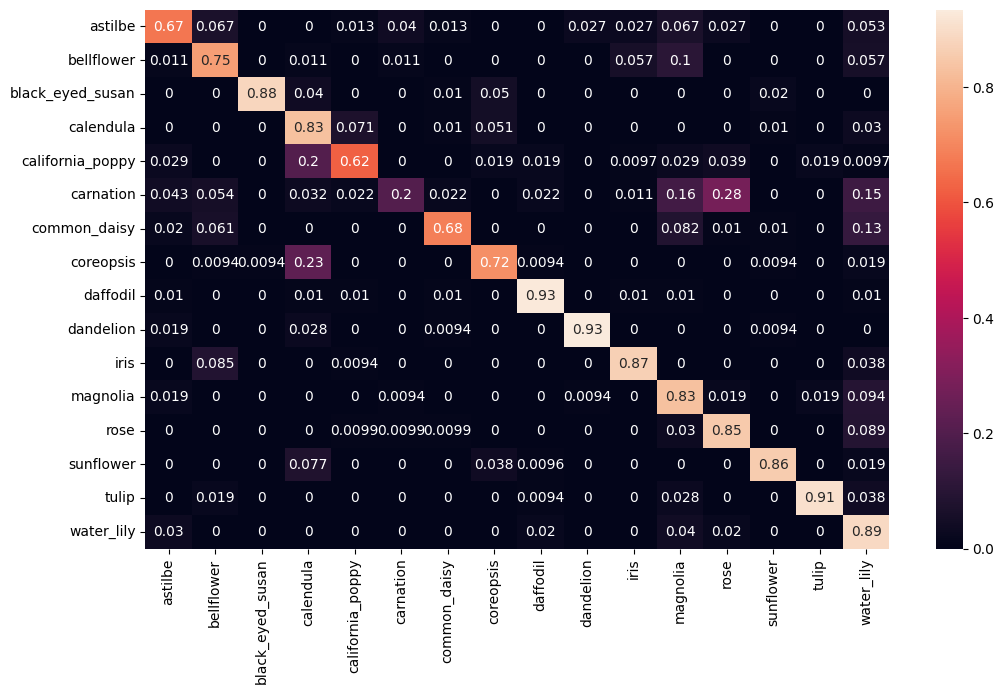

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import numpy as np

y_pred = []
y_true = []

# iterate over test data
for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pandas.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in class_names],
                     columns = [i for i in class_names])
plot.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plot.savefig("R_net_16_Classes_CM.jpg")

In [17]:
torch.save(model, f"./R_net_16_Classes.pth")

In [18]:
dataframe.to_csv("R_net_16_Classes.csv",index=False)

In [19]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [20]:
from sklearn.metrics import accuracy_score, classification_report

print("Overall Accuracy: {:.4f}%".format(accuracy_score(y_true=y_true, y_pred=y_pred)))

print(classification_report(y_true, y_pred,target_names=testing_data.classes))


Overall Accuracy: 0.7813%
                  precision    recall  f1-score   support

         astilbe       0.74      0.67      0.70        75
      bellflower       0.70      0.75      0.73        88
black_eyed_susan       0.99      0.88      0.93       100
       calendula       0.56      0.83      0.67        99
california_poppy       0.83      0.62      0.71       103
       carnation       0.76      0.20      0.32        93
    common_daisy       0.89      0.68      0.77        98
       coreopsis       0.83      0.72      0.77       106
        daffodil       0.91      0.93      0.92        97
       dandelion       0.97      0.93      0.95       106
            iris       0.90      0.87      0.88       106
        magnolia       0.63      0.83      0.72       106
            rose       0.70      0.85      0.77       101
       sunflower       0.94      0.86      0.89       104
           tulip       0.96      0.91      0.93       106
      water_lily       0.55      0.89      0.